In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib

# Configure Matplotlib for Times New Roman font
matplotlib.rc('font', family='Times New Roman', size=14)

# Ensure the figures directory exists
if not os.path.exists('figures'):
    os.makedirs('figures')

def plot_shap_values_for_class_4(model, X_train):
    # Create a TreeExplainer object for the RandomForest model
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # Extract SHAP values for class 4
    class_4_shap_values = shap_values[:, :, 4]

    # Plot beeswarm plot for SHAP values of class 4
    shap.summary_plot(class_4_shap_values, X_train, show=False)
    plt.savefig('figures/beeswarm_SHAP.png')
    plt.close()

# Load data, setup model and cross-validation
data = pd.read_csv('leaveoneout_encoded.csv')
X = data.drop('target', axis=1)
y = data['target']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(random_state=42)

# Train model and generate SHAP visualizations
for train_idx, test_idx in cv.split(X, y):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    model.fit(X_train, y_train)

plot_shap_values_for_class_4(model, X_train)

# Feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n")
print(importance_df.head())



Feature Importances:

         Feature  Importance
2   preservative    0.381020
3  sterilization    0.298645
0    temperature    0.196645
1        package    0.123690


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


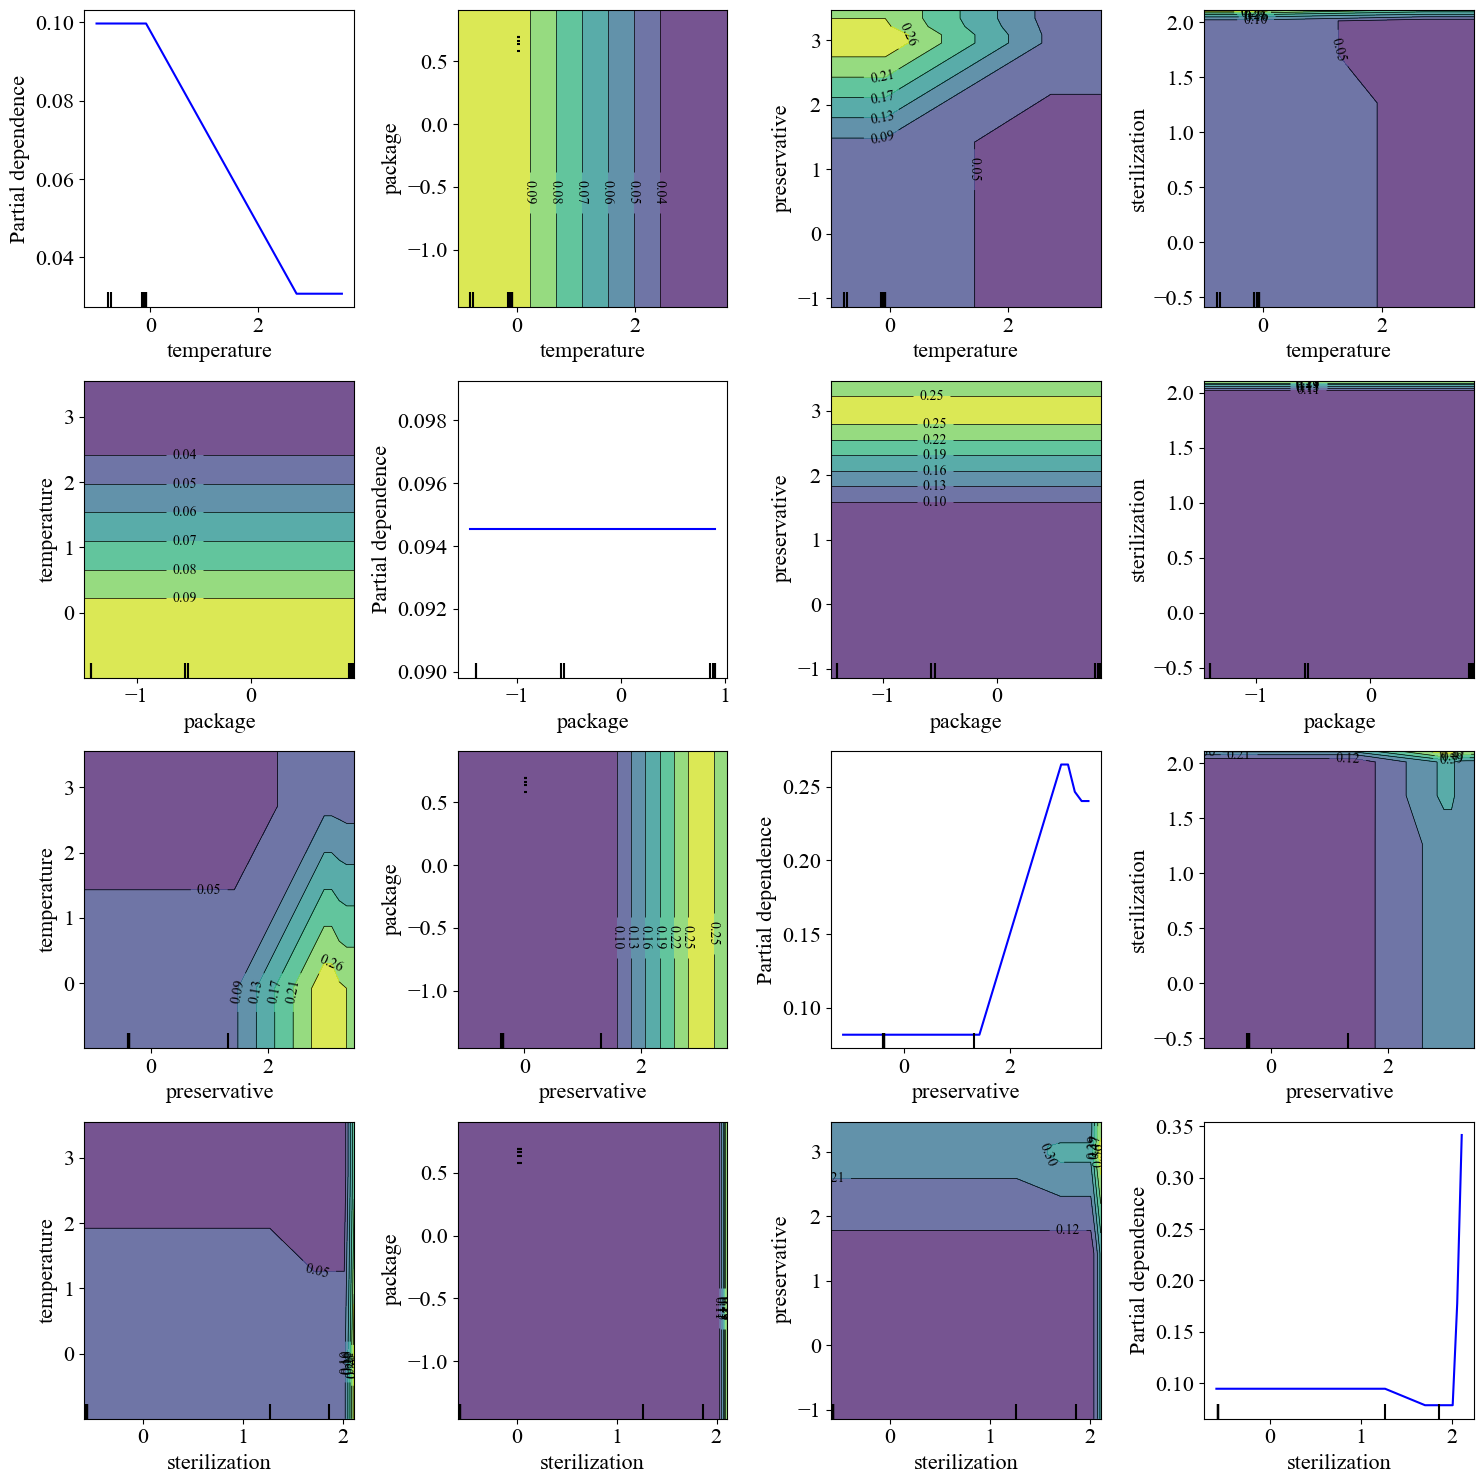

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Set global font sizes for plots
plt.rcParams['font.size'] = 12  # Base size for text elements
plt.rcParams['axes.labelsize'] = 16  # Font size for labels
plt.rcParams['axes.titlesize'] = 16  # Font size for titles
plt.rcParams['xtick.labelsize'] = 16  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 16  # Font size for y-axis tick labels

# Ensure the figures directory exists
if not os.path.exists('figures'):
    os.makedirs('figures')

# Load the model
model_path = r"C:\Users\aim2r\Desktop\GUI\V1_code\best_random_forest_model.pkl"
model = joblib.load(model_path)

# Load and prepare the dataset
X = pd.read_csv('leaveoneout_encoded.csv')
y = X['target']  # Replace 'target' with your actual target column name
feature_cols = ['preservative', 'sterilization', 'temperature', 'package']  # Initial order
X = X[feature_cols]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Reorder features to match model's training order
correct_order = ['temperature', 'package', 'preservative', 'sterilization']  # Model's expected feature order
X_train_scaled = X_train_scaled[correct_order]
X_test_scaled = X_test_scaled[correct_order]

# Define the target class for the partial dependence plot
target_class = model.classes_[4]  # Adjust the index based on your specific class

# Plotting Partial Dependence Plots
fig, axs = plt.subplots(len(correct_order), len(correct_order), figsize=(15, 15), sharey=True, sharex=True)
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        if i == j:
            # Diagonal: One-way PDP
            PartialDependenceDisplay.from_estimator(
                model,
                X_train_scaled,
                features=[i],
                feature_names=correct_order,
                ax=ax,
                line_kw={"color": "blue"},
                target=target_class)
        else:
            # Off-diagonal: Two-way PDP
            PartialDependenceDisplay.from_estimator(
                model,
                X_train_scaled,
                features=[(i, j)],
                feature_names=correct_order,
                ax=ax,
                kind="average",
                contour_kw={"cmap": "viridis"},
                target=target_class)

plt.tight_layout()
plt.show()

# Save the entire figure
fig.savefig('figures/full_partial_dependence_plot.png')
